In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
'''!pip install pyarrow==8.0.0
!pip install apache_beam==2.34.0
!pip install tensorflow_data_validation==1.16.1'''

'!pip install pyarrow==8.0.0\n!pip install apache_beam==2.34.0\n!pip install tensorflow_data_validation==1.16.1'

In [20]:
import tensorflow_data_validation as tfdv
from IPython.display import display, HTML
import pyarrow
import apache_beam as beam
import tensorflow_data_validation

In [21]:
#handle the data
import pandas as pd
import numpy as np
from scipy import stats

In [22]:
#to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#to preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
#import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB

#pipeline
from sklearn.pipeline import Pipeline
#metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score

import warnings

In [23]:
#load dataset
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/DATASETS/Telco-Customer-Churn.csv'))
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [24]:
#DATA VISUALIZATION
df_stats = tfdv.generate_statistics_from_dataframe(dataframe=df[[col for col in df.columns if col != 'customerID']])
display(tfdv.visualize_statistics(df_stats))

None

In [25]:
#Preprocessing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [26]:
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)

In [29]:
class DataFrameEncoder:
    def __init__(self, df):
        self.df = df
        self.encoder = OneHotEncoder(sparse_output=False)

    def encode_categorical_columns(self):
        categorical_cols = self.df.select_dtypes(include=['category', 'object']).columns
        encoded_data = self.encoder.fit_transform(self.df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=self.encoder.get_feature_names_out(categorical_cols))
        self.df.drop(columns=categorical_cols, inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        self.df = pd.concat([self.df, encoded_df], axis=1)

    def get_encoded_df(self):
        return self.df

In [35]:
df_encoder = DataFrameEncoder(df)
df_encoder.encode_categorical_columns()
df = df_encoder.get_encoded_df()
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,1,29.85,29.85,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,34,56.95,1889.50,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0,2,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,45,42.30,1840.75,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,2,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [36]:
df.drop('Churn_No', axis=1, inplace=True)
df.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)

In [37]:
#split data into X and Y
X = df.drop('Churn', axis=1)
y = df['Churn']
print(X.columns)

#data into train and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', '

In [38]:
from os import pipe
#MODEL TRAINING
model = GaussianNB()

pipeline=Pipeline([('scaler', StandardScaler()), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6837242359630419


<ipython-input-39-d6c7974c1f23>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = initial_df.corr()


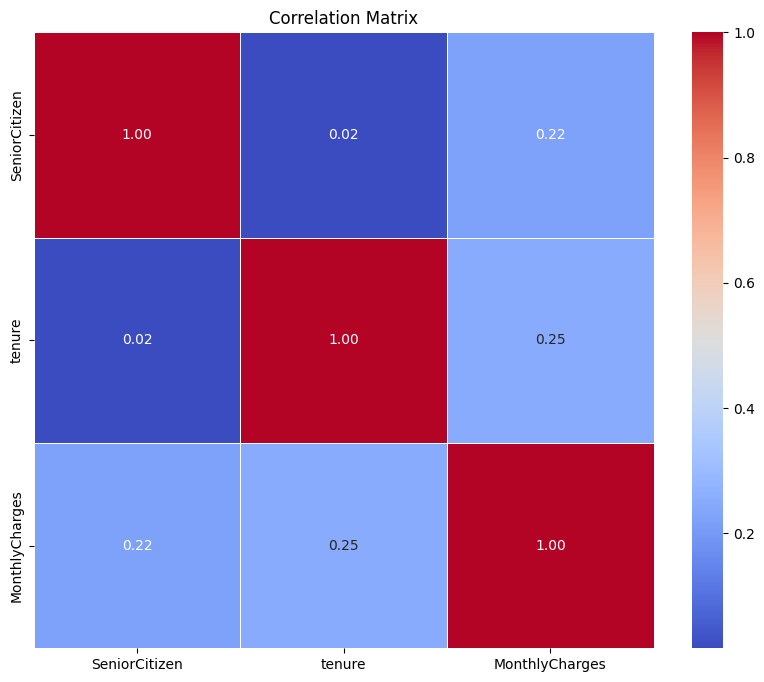

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

initial_df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/DATASETS/Telco-Customer-Churn.csv'))

correlation_matrix = initial_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


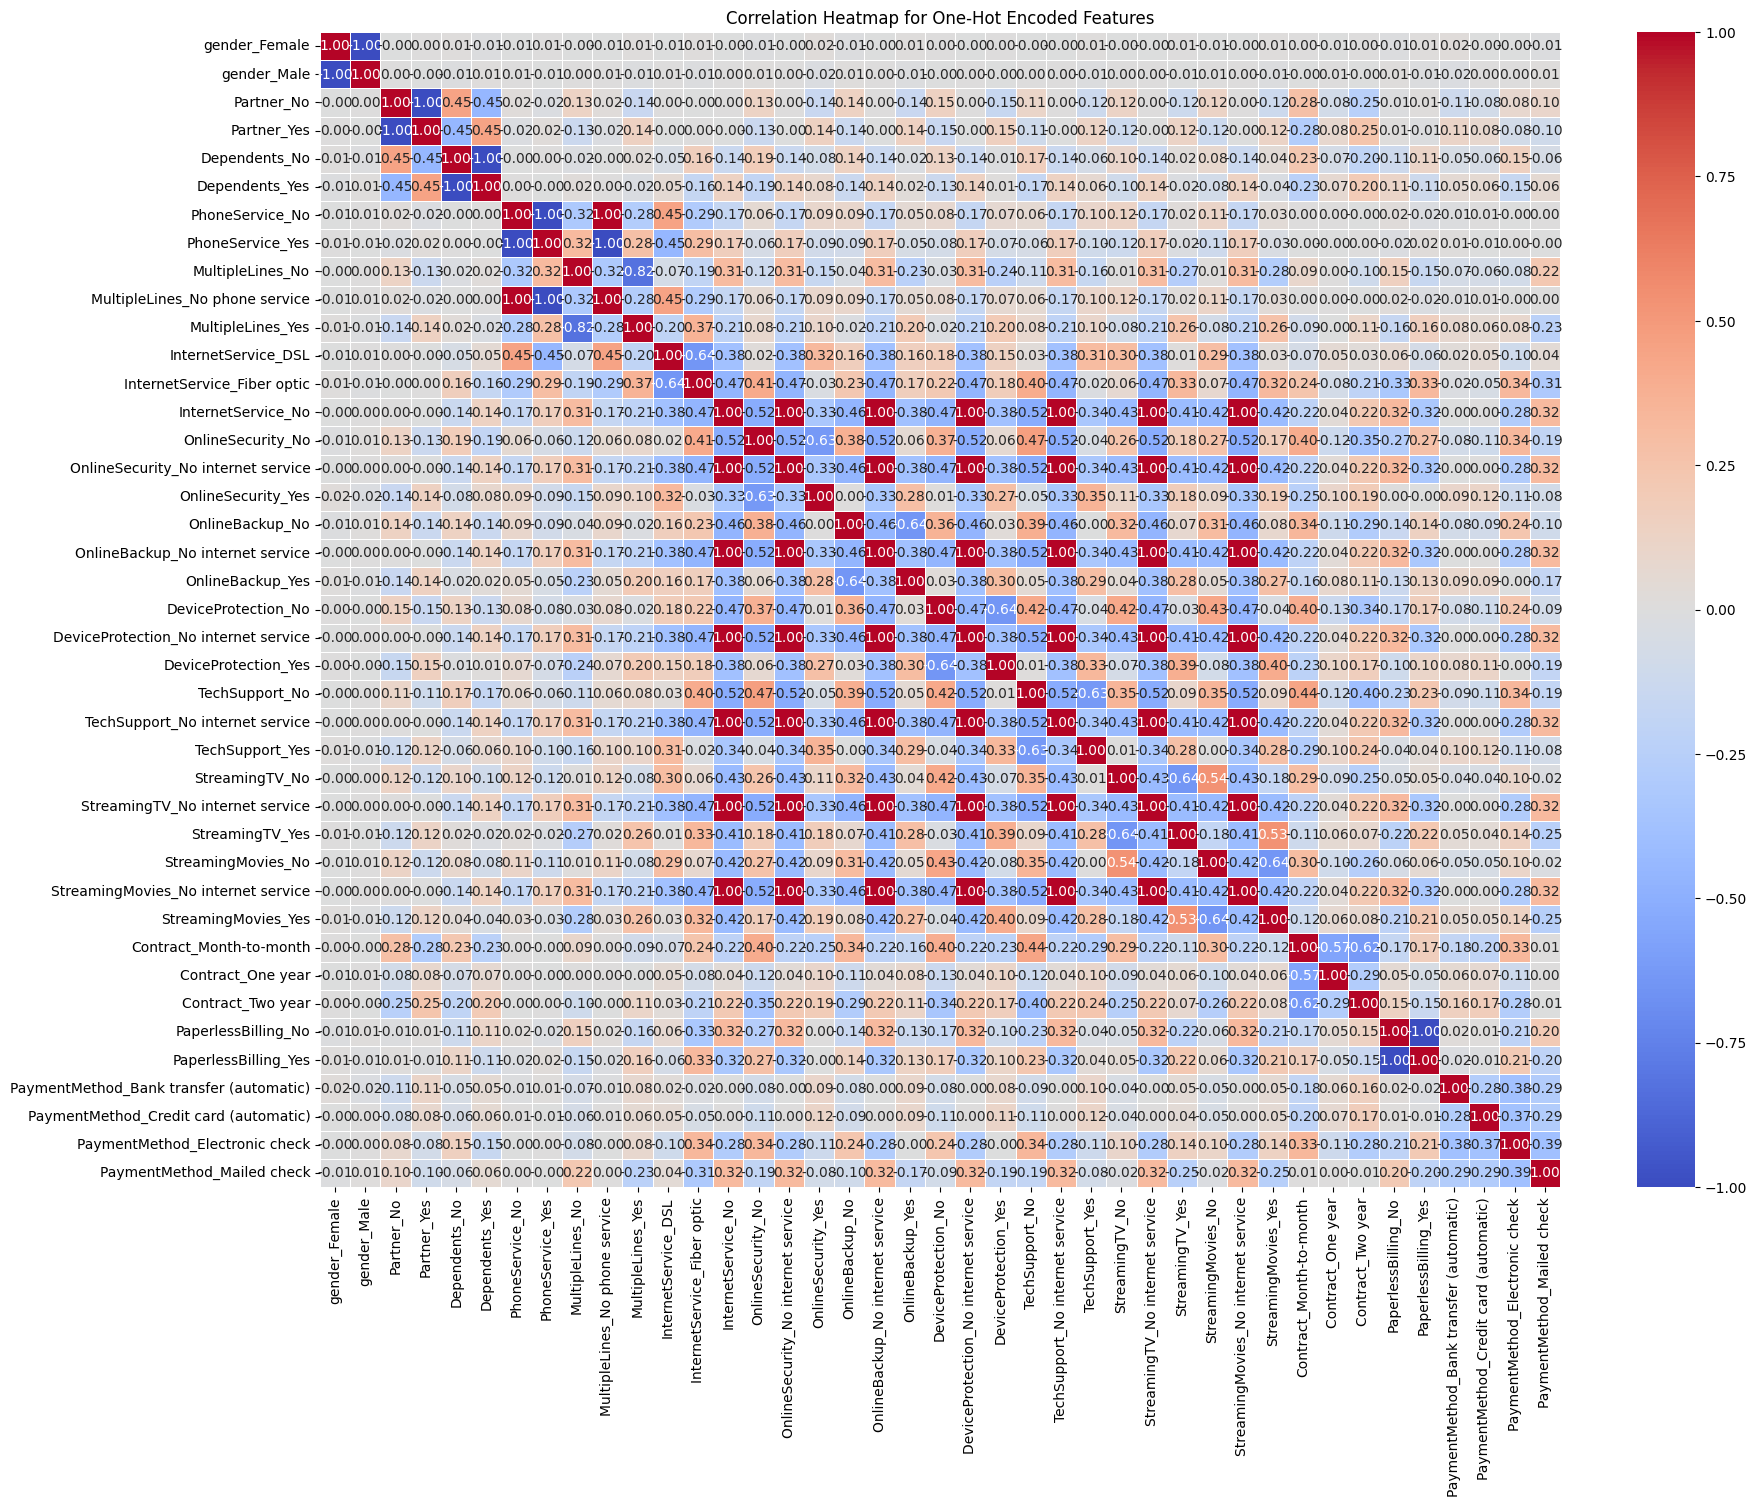

In [40]:
one_hot_cols = [col for col in df.columns if '_' in col]

# Step 2: Calculate the correlation matrix for only one-hot encoded columns
correlation_matrix = df[one_hot_cols].corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for One-Hot Encoded Features')
plt.show()

In [41]:
columns_to_delete = ['InternetService_No','OnlineSecurity_No internet service', 'OnlineBackup_No internet service','DeviceProtection_No internet service', 'TechSupport_No internet service','StreamingTV_No internet service','StreamingMovies_No internet service']

In [42]:
X = X.drop(columns=columns_to_delete, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
model = GaussianNB()

pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
print(accuracy)

0.7427149964463398
